In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

# Heston Simulation

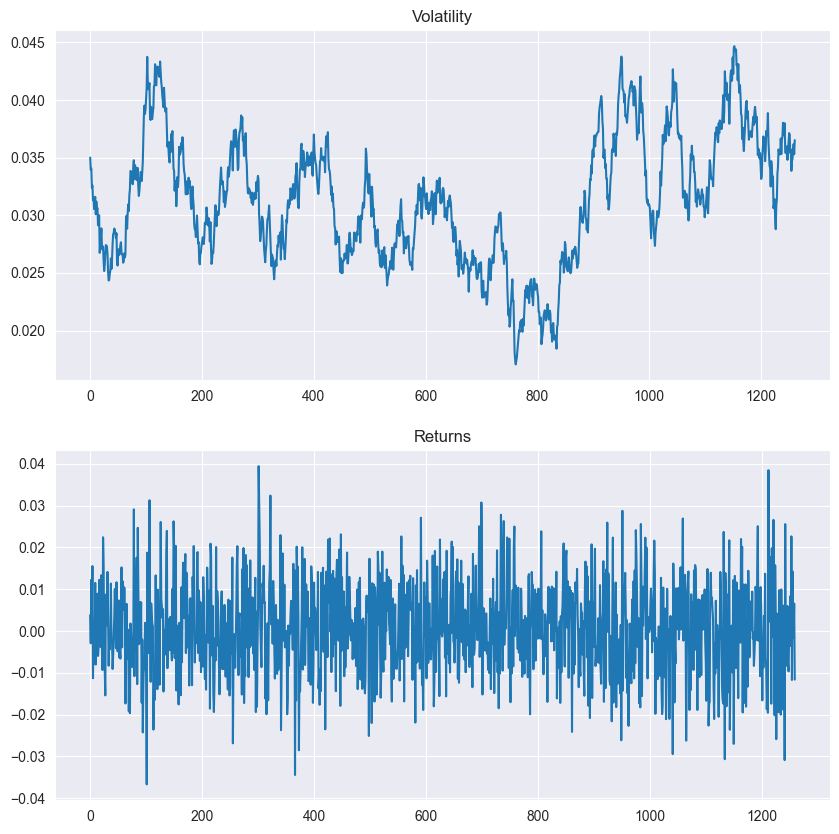

In [6]:
from numpy.random import standard_normal as std_normal

DT = 1/252
T = 252 * 5
X0 = 0.035
THETA = 0.035
KAPPA = 4
RHO = -0.8
CHI = 0.008

def heston_simulation(x0 = X0, theta = THETA, kappa = KAPPA, chi = CHI, rho = RHO):
    x_samples = np.zeros(T+1)
    y_samples = np.zeros(T)
    x_samples[0] = x0
    x_curr = x0
    eps_x = np.sqrt(DT) * std_normal(T)
    eps_y = np.sqrt(DT) * std_normal(T)
    for it in range(0, T):
        y_samples[it] = (x_samples[it] * DT / 2 + np.sqrt(x_samples[it]) * rho * eps_x[it]
                           + np.sqrt(x_samples[it] * (1 - rho ** 2)) * eps_y[it])
        x_curr += kappa * (theta - x_curr) * DT + np.sqrt(x_curr * chi) * eps_x[it]
        x_samples[it+1] = x_curr
    return x_samples, y_samples

X, Y = heston_simulation()

_, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(X)
ax[0].set_title(f'Volatility')
ax[1].plot(Y)
ax[1].set_title(f'Returns')
plt.show()

In [7]:
print(f"Volatility mean: {np.mean(X):.3f}")
print(f"Returns mean: {np.mean(Y):.4f}")

Volatility mean: 0.031
Returns mean: 0.0006


# Bootstrap Particle Filter

In [8]:
def norm_pdf(vals, means, stds):
    norm_ct = 1 / (np.sqrt(2 * np.pi) * stds)
    return norm_ct * np.exp(-(vals - means)**2 / (2 * (stds ** 2)))

def markov_conditional(x_prop, x_curr, theta, kappa, chi):
    return norm_pdf(x_prop - x_curr,
                    kappa * (theta - x_curr) * DT,
                    np.sqrt(x_curr * DT * chi))

def markov_transition(x_curr, theta, kappa, chi):
    err_x = np.sqrt(DT) * std_normal(len(x_curr))
    x_trans = (x_curr + kappa * (theta - x_curr) * DT
               +  np.sqrt(x_curr * chi) * err_x)
    return x_trans, err_x

def return_conditional_vol(y, x, err, rho):
    return norm_pdf(y,
                    - (x / 2) * DT + rho * np.sqrt(x) * err,
                    np.sqrt((1 - rho**2) * x * DT))

def get_weights(y_curr, x_prev, err, rho):
    return return_conditional_vol(y_curr, x_prev, err, rho)

def bootstrap_resampler(x_curr, weights_norm):
    ancestors = np.random.choice(np.arange(len(x_curr)),
                                 size=len(x_curr),
                                 replace=True,
                                 p=weights_norm)
    return x_curr[ancestors], ancestors

def bootstrap_filter(theta, kappa, chi, rho, n_particles = 400, reference_x = False, x0 = X0):
    x_samples = np.zeros((T+1, n_particles))
    x_samples[0, :] = X0
    err_samples = np.zeros((T, n_particles))
    weights = np.zeros((T, n_particles))
    ancestors = np.zeros((T, n_particles))
    ancestors[0, :] = np.arange(n_particles)

    x_samples[1, :], err_samples[0, :] = markov_transition(np.zeros(n_particles) + x0, theta, kappa, chi)
    weights[0, :] = get_weights(Y[0], x_samples[0, :], err_samples[0, :], rho)
    if reference_x:
        x_samples[0, -1] = reference_x[0]

    for it in range(1, T):
        x_resamp, ancestors[it, :] = bootstrap_resampler(x_samples[it, :], weights[it-1, :]/weights[it-1, :].sum())
        x_samples[it+1, :], err_samples[it, :] = markov_transition(x_resamp, theta, kappa, chi)
        if reference_x:
            x_samples[it, -1] = reference_x[it]

        weights[it, :] = get_weights(Y[it], x_samples[it, :], err_samples[it, :], rho)

    return x_samples, weights, ancestors

def get_full_path(k, x_samples, ancestors):
    path = np.zeros(T+1)
    path[0] = X0
    path[-1] = x_samples[-1, k]
    curr_ind = k
    for it in range(1, T):
        curr_ind = int(ancestors[-it, curr_ind])
        path[-it - 1] = x_samples[-it - 1, curr_ind]
    return path

def sample_full_path(x_samples, ancestors, weights):
    n_particles = len(x_samples[0, :])
    index = np.random.choice(np.arange(n_particles), p=weights[-1, :]/weights[-1, :].sum())
    path = get_full_path(index, x_samples, ancestors)
    return path

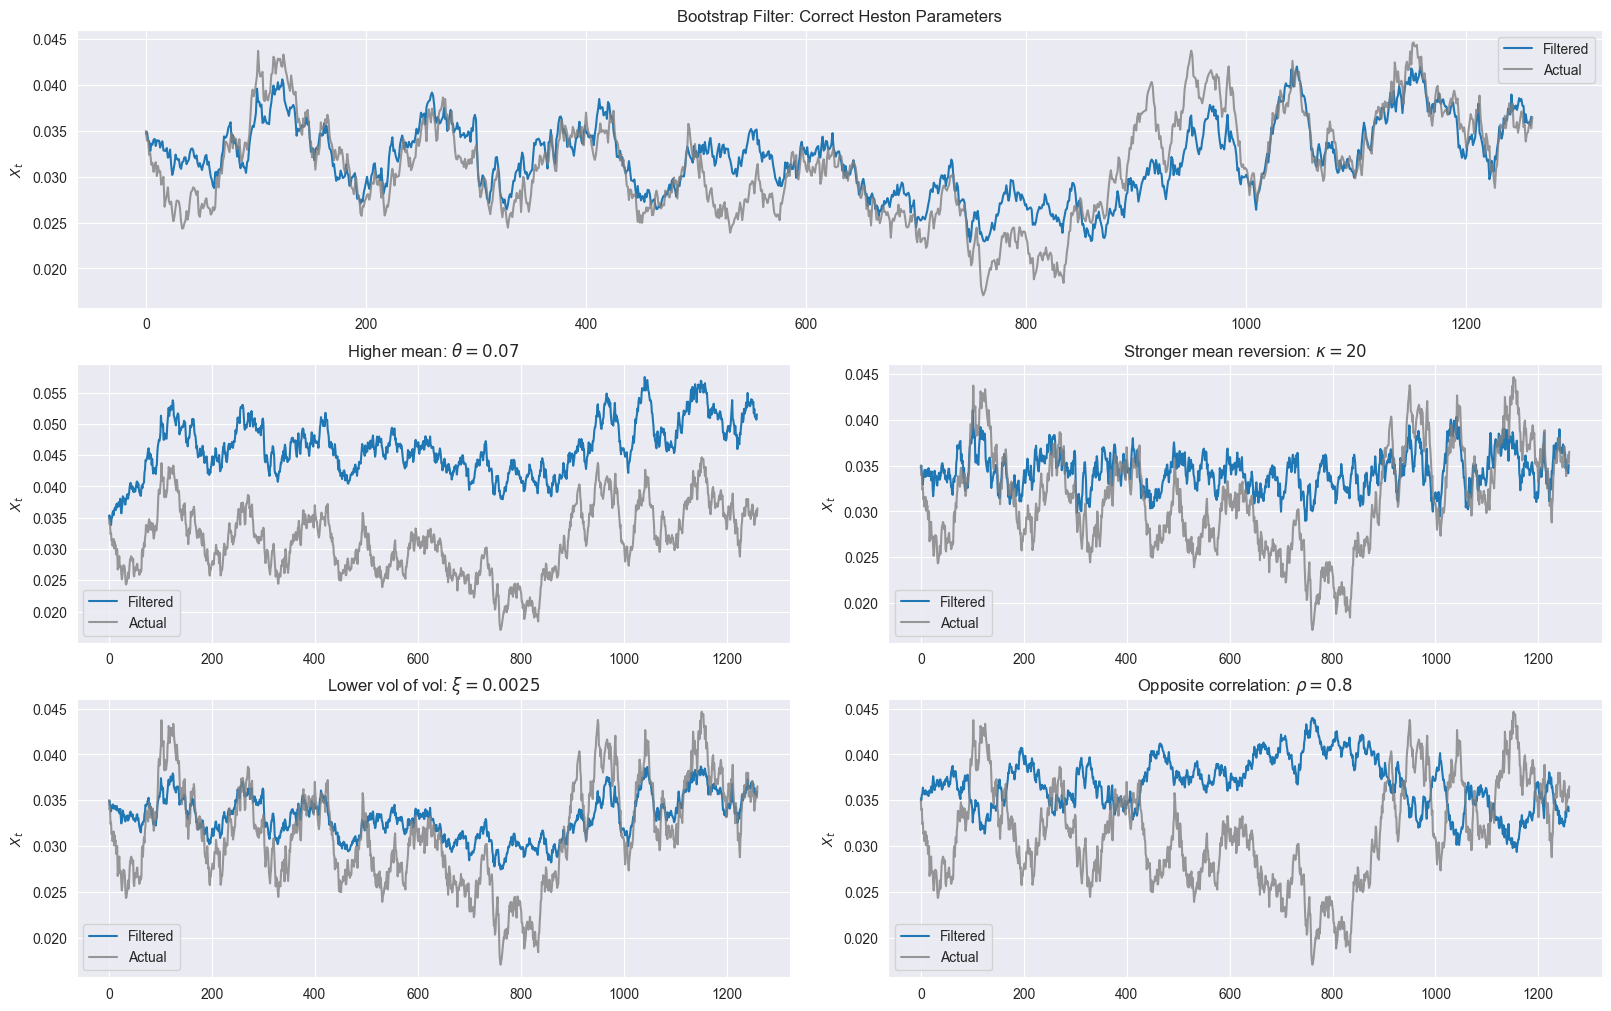

In [79]:
import matplotlib.gridspec as gridspec

x_test, weights_test, ancestors_test = bootstrap_filter(THETA, KAPPA, CHI, RHO, n_particles=2000)
x_estimated = (x_test[1:] * (weights_test / weights_test.sum(axis=1, keepdims=True))).sum(axis=1)

x_test_theta, weights_test_theta, _ = bootstrap_filter(0.05, KAPPA, CHI, RHO, n_particles=2000)
x_estimated_theta = (x_test_theta[1:] * (weights_test_theta / weights_test_theta.sum(axis=1, keepdims=True))).sum(axis=1)

x_test_kappa, weights_test_kappa, _ = bootstrap_filter(THETA, 20, CHI, RHO, n_particles=2000)
x_estimated_kappa = (x_test_kappa[1:] * (weights_test_kappa / weights_test_kappa.sum(axis=1, keepdims=True))).sum(axis=1)

x_test_chi, weights_test_chi, _ = bootstrap_filter(THETA, KAPPA, 0.0025, RHO, n_particles=2000)
x_estimated_chi = (x_test_chi[1:] * (weights_test_chi / weights_test_chi.sum(axis=1, keepdims=True))).sum(axis=1)

x_test_rho, weights_test_rho, _ = bootstrap_filter(THETA, KAPPA, CHI, 0.5, n_particles=2000)
x_estimated_rho = (x_test_rho[1:] * (weights_test_rho / weights_test_rho.sum(axis=1, keepdims=True))).sum(axis=1)

fig = plt.figure(constrained_layout=True, figsize=(16, 10))
gs = gridspec.GridSpec(3, 2, figure=fig)

ax_top = fig.add_subplot(gs[0, :])
ax_top.plot(x_estimated, label='Filtered')
ax_top.plot(X, label='Actual',  color = 'gray', alpha=0.8)
ax_top.set_title('Bootstrap Filter: Correct Heston Parameters')
ax_top.set_ylabel(r'$X_t$')
ax_top.legend()

ax_theta = fig.add_subplot(gs[1, 0])
ax_theta.plot(x_estimated_theta, label='Filtered')
ax_theta.plot(X, label='Actual',  color = 'gray', alpha=0.8)
ax_theta.set_title(r'Higher mean: $\theta = 0.07$')
ax_theta.set_ylabel(r'$X_t$')
ax_theta.legend()

ax_kappa = fig.add_subplot(gs[1, 1])
ax_kappa.plot(x_estimated_kappa, label='Filtered')
ax_kappa.plot(X, label='Actual',  color = 'gray', alpha=0.8)
ax_kappa.set_title(r'Stronger mean reversion: $\kappa = 20$')
ax_kappa.set_ylabel(r'$X_t$')
ax_kappa.legend()

ax_chi = fig.add_subplot(gs[2, 0])
ax_chi.plot(x_estimated_chi, label='Filtered')
ax_chi.plot(X, label='Actual',  color = 'gray', alpha=0.8)
ax_chi.set_title(r'Lower vol of vol: $\xi = 0.0025$')
ax_chi.set_ylabel(r'$X_t$')
ax_chi.legend()

ax_rho = fig.add_subplot(gs[2, 1])
ax_rho.plot(x_estimated_rho, label='Filtered')
ax_rho.plot(X, label='Actual',  color = 'gray', alpha=0.8)
ax_rho.set_title(r'Opposite correlation: $\rho = 0.8$')
ax_rho.set_ylabel(r'$X_t$')
ax_rho.legend()

plt.show()

# Posterior Likelihood Curves

Priors $\theta \sim N(0.035, 10)$, $\kappa \sim N(3, 100)$, $\chi \sim N(0.007, 10)$, $\rho \sim \text{ Unif}(-1, 1)$.

In [10]:
def theta_prior(theta):
    return norm_pdf(theta, 0.035, 10)

def kappa_prior(kappa):
    return norm_pdf(kappa, 4, 100)

def chi_prior(chi):
    return norm_pdf(chi, 0.008, 10)

In [11]:
def log_likelihood_params(weights):
    return np.sum(np.log(weights.sum(axis = 1)))

def log_posterior_params(weights, theta, kappa, chi):
    if kappa < 1.5 or chi < 0.0001 or chi > 0.02:
        return 0
    return (log_likelihood_params(weights) + np.log(theta_prior(theta))
            + np.log(kappa_prior(kappa)) + np.log(chi_prior(chi)))

In [12]:
from tqdm.notebook import tqdm

n_points = 50
n_trials = 10
n_particles = 2000

thetas = np.linspace(0.015, 0.05, n_points)
post_thetas = []

kappas = np.linspace(1.5, 40, n_points)
post_kappas = []

chis = np.linspace(0.0005, 0.017, n_points)
post_chis = []

rhos = np.linspace(-0.95, 0.95, n_points)
post_rhos = []

for theta in tqdm(thetas):
    tmp_lik = []
    for _ in range(n_trials):
        _, temp_w, _ = bootstrap_filter(theta, KAPPA, CHI, RHO, n_particles = n_particles)
        tmp_lik.append(log_posterior_params(temp_w, theta, KAPPA, CHI))
    post_thetas.append(tmp_lik)

for kappa in tqdm(kappas):
    tmp_lik = []
    for _ in range(n_trials):
        _, temp_w, _ = bootstrap_filter(THETA, kappa, CHI, RHO, n_particles = n_particles)
        tmp_lik.append(log_posterior_params(temp_w, THETA, kappa, CHI))
    post_kappas.append(tmp_lik)

for chi in tqdm(chis):
    tmp_lik = []
    for _ in range(n_trials):
        _, temp_w, _ = bootstrap_filter(THETA, KAPPA, chi, RHO, n_particles = n_particles)
        tmp_lik.append(log_posterior_params(temp_w, THETA, KAPPA, chi))
    post_chis.append(tmp_lik)

for rho in tqdm(rhos):
    tmp_lik = []
    for _ in range(n_trials):
        _, temp_w, _ = bootstrap_filter(THETA, KAPPA, CHI, rho, n_particles = n_particles)
        tmp_lik.append(log_posterior_params(temp_w, THETA, KAPPA, CHI))
    post_rhos.append(tmp_lik)

post_thetas = np.array(post_thetas)
post_kappas = np.array(post_kappas)
post_chis = np.array(post_chis)
post_rhos = np.array(post_rhos)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

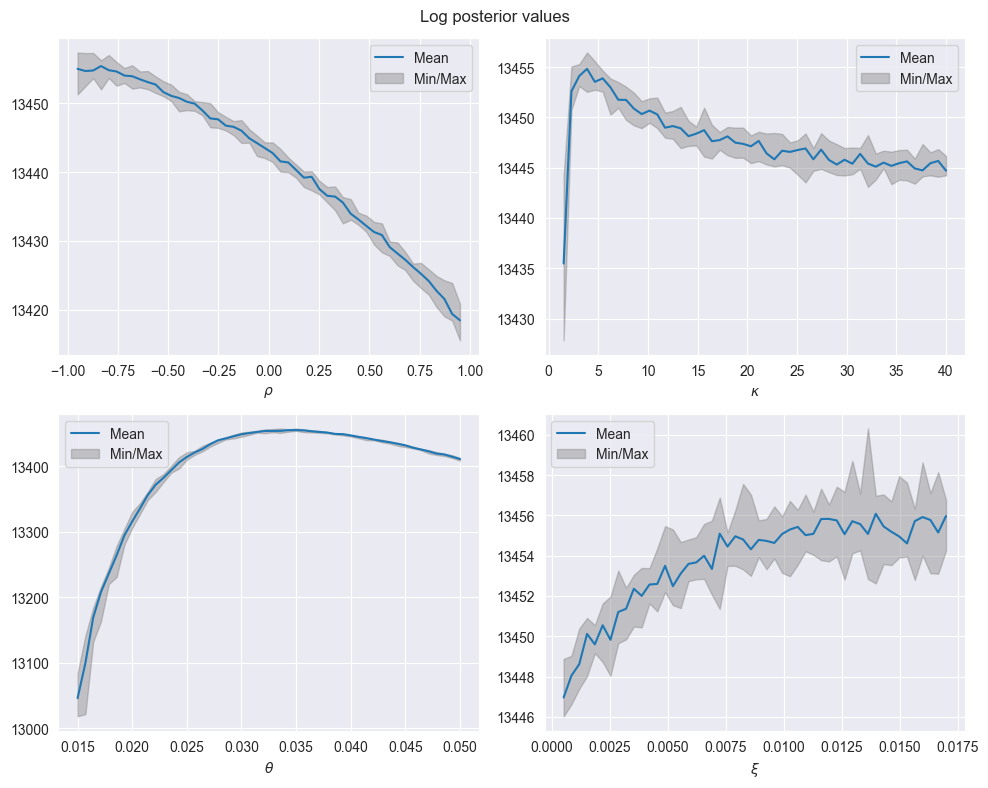

In [72]:
med_thetas = np.median(post_thetas, axis=1)
min_thetas = np.min(post_thetas, axis=1)
max_thetas = np.max(post_thetas, axis=1)

med_kappas = np.median(post_kappas, axis=1)
min_kappas = np.min(post_kappas, axis=1)
max_kappas = np.max(post_kappas, axis=1)

med_chis = np.median(post_chis, axis=1)
min_chis = np.min(post_chis, axis=1)
max_chis = np.max(post_chis, axis=1)

med_rhos = np.median(post_rhos, axis=1)
min_rhos = np.min(post_rhos, axis=1)
max_rhos = np.max(post_rhos, axis=1)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[1,0].plot(thetas, med_thetas, label='Mean')
axs[1,0].fill_between(thetas, min_thetas, max_thetas, color='gray', alpha=0.4, label = 'Min/Max')
axs[1,0].set_xlabel(r'$\theta$')
axs[1,0].legend()

axs[0,1].plot(kappas, med_kappas,  label='Mean')
axs[0,1].fill_between(kappas, min_kappas, max_kappas, color='gray', alpha=0.4, label = 'Min/Max')
axs[0,1].set_xlabel(r'$\kappa$')
axs[0,1].legend()

axs[1,1].plot(chis, med_chis, label='Mean')
axs[1,1].fill_between(chis, min_chis, max_chis, color='gray', alpha=0.4, label = 'Min/Max')
axs[1,1].set_xlabel(r'$\xi$')
axs[1,1].legend()

axs[0,0].plot(rhos, med_rhos, label='Mean')
axs[0,0].fill_between(rhos, min_rhos, max_rhos, color='gray', alpha=0.4, label = 'Min/Max')
axs[0,0].set_xlabel(r'$\rho$')
axs[0,0].legend()

plt.suptitle("Log posterior values")
plt.tight_layout()
plt.show()

# Particle Marginal Metropolis-Hastings

The proposal kernel needs to preserve $\xi < 2 \kappa \theta$. Due to discretization error, I had to enforce $\xi < \kappa \theta /2$ otherwise some negative values for $X_t$ were generated. Let $$a = \log \kappa  + \log \theta - \log 2 \xi,\hspace{1cm} \,b = \log \kappa, \hspace{1cm}\,c = \log \theta.$$
Then the constraint is simply $a > 0$. Instead of transforming $a$ by simply $\log$, which skews the proposals too heavily towards $\xi / \kappa \theta \to 0$, let $f: \mathbb{R}^+ \to \mathbb{R}$ be:
$$f(x) = \begin{cases} x-1, \text{ if } x \geq 1 \\ \log x, \text{ if } 0 <x < 1 \end{cases}$$
and let $a' = f(a)$. We transform $\theta$ by $\theta' = \tan(\pi \theta/2)$ and use a $N(0, \sigma^2 I)$ proposal in $\theta', a', b, c$ coordinates.

In [24]:
# Use tan and log transformations to maintain parameters in valid range
def aux_transform(x):
    return (x-1) if x >= 1 else np.log(x)

def aux_transform_inv(x):
    return (x+1) if x >= 0 else np.exp(x)

def transform(rho, kappa, theta, chi):
    t_rho = np.tan(np.pi * rho / 2)
    b = np.log(kappa)
    c = np.log(theta)
    a = aux_transform(b + c - np.log(chi))
    return np.array([t_rho, a, b, c])

def inverse_transform(params):
    t_rho, a, b, c = params[0], params[1], params[2], params[3]
    rho = 2/np.pi * np.arctan(t_rho)
    kappa = np.exp(b)
    theta = np.exp(c)
    chi = np.exp((b + c - aux_transform_inv(a)))
    return np.array([rho, kappa, theta, chi])

In [34]:
def pmmh_sampler(theta_init = 1/20, kappa_init = 3, chi_init = 1/200, rho_init = 0,
                 n_iter =  10**4, n_particles = 1000, step_size = 1e-2,
                 fix_chi = False, fix_kappa = False):

    rho_curr, kappa_curr, theta_curr, chi_curr = rho_init, kappa_init, theta_init, chi_init
    rho_samples = np.zeros(n_iter)
    kappa_samples = np.zeros(n_iter)
    theta_samples = np.zeros(n_iter)
    chi_samples = np.zeros(n_iter)

    # Initialize
    _, weights_curr, _ = bootstrap_filter(theta_curr, kappa_curr, chi_curr, rho_curr, n_particles)
    posterior_curr = log_posterior_params(weights_curr, theta_curr, kappa_curr, chi_curr)

    acc_count = 0
    for it in tqdm(range(n_iter)):
        # Proposal
        if fix_chi and fix_kappa:
            kappa_prop = kappa_init
            chi_prop = chi_init
            theta_prop = theta_curr * np.exp(step_size * std_normal())
            rho_prop = 2/np.pi * np.arctan(np.tan(np.pi * rho_curr / 2) + step_size * std_normal())

        else:
            rho_prop, kappa_prop, theta_prop, chi_prop = inverse_transform(
                transform(rho_curr, kappa_curr, theta_curr, chi_curr) + step_size
                * np.random.multivariate_normal(np.zeros(4), np.diag([5, 1, 1, 1])))

        #Run bootstrap filter and compute acceptance ratio
        _, weights_prop, _ = bootstrap_filter(theta_prop, kappa_prop, chi_curr, rho_prop, n_particles)
        posterior_prop = log_posterior_params(weights_prop, theta_prop, kappa_prop, chi_prop)

        #Accept/reject and update
        if np.log(np.random.rand()) < posterior_prop - posterior_curr:
            acc_count += 1
            posterior_curr = posterior_prop
            rho_curr = rho_prop
            theta_curr = theta_prop
            chi_curr = chi_prop
            kappa_curr = kappa_prop

        rho_samples[it] = rho_curr
        kappa_samples[it] = kappa_curr
        theta_samples[it] = theta_curr
        chi_samples[it] = chi_curr

    return rho_samples, kappa_samples, theta_samples, chi_samples, acc_count/n_iter

  0%|          | 0/5000 [00:00<?, ?it/s]

Acceptance rate: 0.256
rho mean: -0.798
kappa mean: 3.912
theta mean: 0.035
chi mean: 0.009


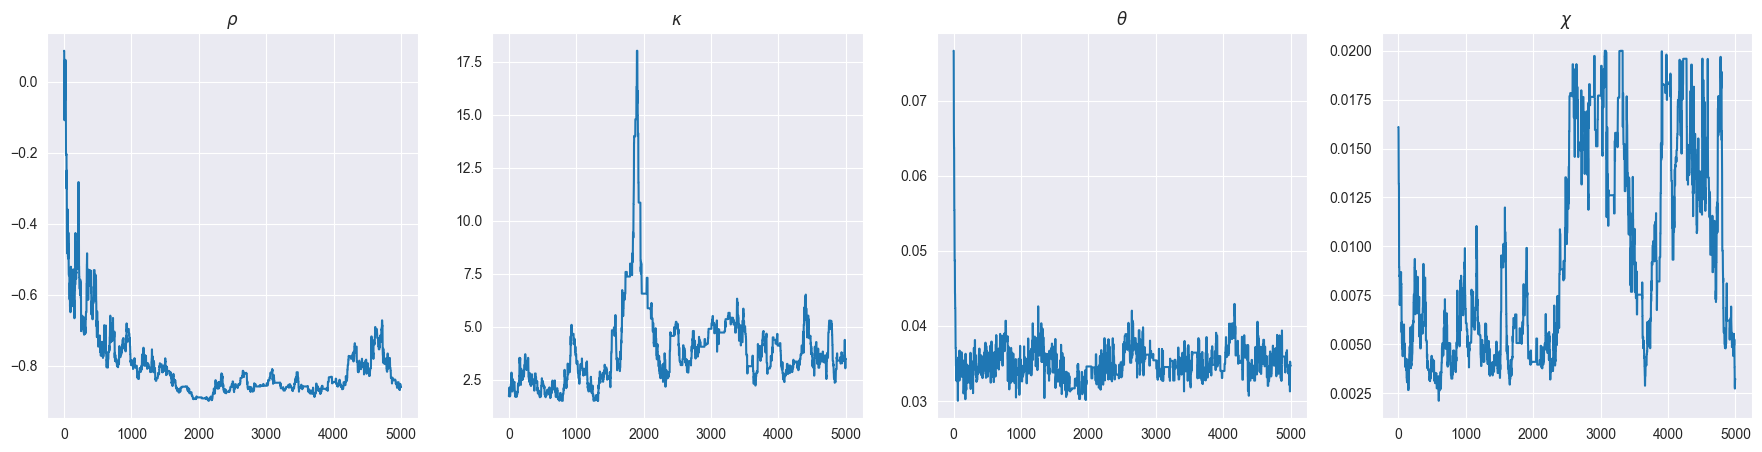

In [43]:
rho_samp, kappa_samp, theta_samp, chi_samp, acc= pmmh_sampler(theta_init = 0.08, kappa_init = 2, chi_init = 1/50, rho_init = 0,
                                                              n_iter = 5 * 10**3, n_particles= 2000, step_size = 0.07,
                                                              fix_chi = False, fix_kappa = False)
print(f"Acceptance rate: {acc:.3f}")
print(f"rho mean: {rho_samp.mean():.3f}")
print(f"kappa mean: {kappa_samp.mean():.3f}")
print(f"theta mean: {theta_samp.mean():.3f}")
print(f"chi mean: {chi_samp.mean():.3f}")

_, ax = plt.subplots(1, 4, figsize=(22, 5))
ax[0].plot(rho_samp)
ax[0].set_title(r"$\rho$")
ax[1].plot(kappa_samp)
ax[1].set_title(r"$\kappa$")
ax[2].plot(theta_samp)
ax[2].set_title(r"$\theta$")
ax[3].plot(chi_samp)
ax[3].set_title(r"$\chi$")
plt.show()

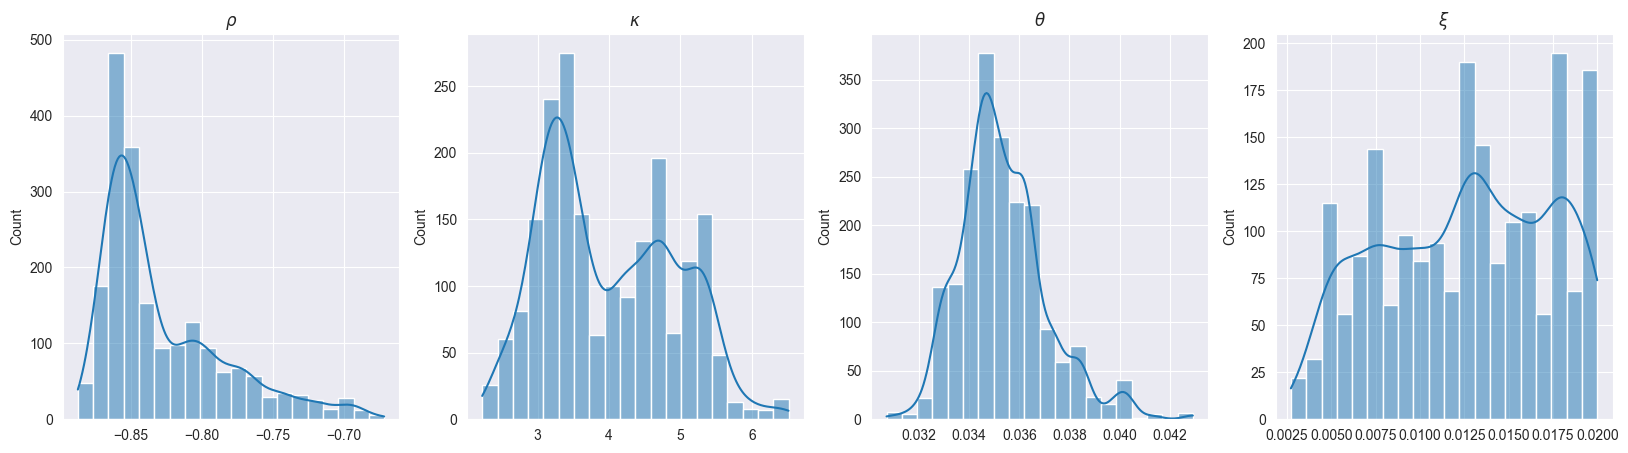

In [64]:
_, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(rho_samp[3000:5000], bins=20, kde = True, ax=ax[0])
ax[0].set_title(r"$\rho$")
sns.histplot(kappa_samp[3000:5000], bins=20, kde = True, ax=ax[1])
ax[1].set_title(r"$\kappa$")
sns.histplot(theta_samp[3000:5000], bins=20, kde = True, ax=ax[2])
ax[2].set_title(r"$\theta$")
sns.histplot(chi_samp[3000:5000], bins=20, kde = True, ax=ax[3])
ax[3].set_title(r"$\xi$")

plt.show()

In [48]:
samples_df = pd.DataFrame({'rho': rho_samp[3000:5000], 'kappa': kappa_samp[3000:5000], 'theta': theta_samp[3000:5000], 'chi': chi_samp[3000:5000]})

samples_df.describe(percentiles = [0.05, 0.95])

,rho,kappa,theta,chi
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,-0.827665,3.992767,0.035353,0.012555
std,0.044152,0.923293,0.001742,0.004732
min,-0.887444,2.224770,0.030707,0.002729
5%,-0.872465,2.717556,0.032843,0.004848
50%,-0.845895,3.756210,0.035079,0.012822
95%,-0.732971,5.422168,0.038507,0.019592
max,-0.671630,6.513012,0.042925,0.019998


In [61]:
samples_df.corr()

,rho,kappa,theta,chi
rho,1.000000,-0.144125,-0.007585,0.173526
kappa,-0.144125,1.000000,-0.444816,0.456228
theta,-0.007585,-0.444816,1.000000,0.128426
chi,0.173526,0.456228,0.128426,1.000000


# Random Walk Metropolis-Hastings

In [74]:
def path_likelihood(x_path, rho, kappa, theta, chi):
    errs = (x_path[1:] - x_path[:-1] - kappa * (theta - x_path[:-1]) * DT) / np.sqrt(x_path[:-1] * chi)
    markov_lik = np.log(markov_conditional(x_path[1:], x_path[:-1], kappa, theta, chi))
    obs_lik = np.log(return_conditional_vol(Y, x_path[:-1], errs, rho))
    return np.sum(markov_lik) + np.sum(obs_lik)

def posterior_path(x_path, rho, kappa, theta, chi):
    if kappa < 1.5 or chi < 0.0001 or chi > 0.018:
        return 0
    return path_likelihood(x_path, rho, kappa, theta, chi) + chi_prior(chi) + kappa_prior(kappa) + theta_prior(theta)


def rwmh_sampler(x0 = X0, theta_init = 0.08, kappa_init = 2, chi_init = 1/200, rho_init = 0,
                 n_iter = 2 * 10**6, step_size = 1e-5, burn_in = 10**6, thinning = 100):

    n_samp = int((n_iter-burn_in)/thinning)
    x_paths_samples = np.zeros((n_samp, T+1))
    rho_samp, kappa_samp, theta_samp, chi_samp = np.zeros(n_samp), np.zeros(n_samp), np.zeros(n_samp), np.zeros(n_samp)
    rho_curr, kappa_curr, theta_curr, chi_curr = rho_init, kappa_init, theta_init, chi_init
    x_path_curr = np.zeros(T+1) + x0
    curr_post = posterior_path(x_path_curr, rho_curr, kappa_curr, theta_curr, chi_curr)
    acc_count = 0

    for it in tqdm(range(n_iter)):
        x_path_prop = x_path_curr * np.exp(step_size * std_normal(T+1))
        rho_prop, kappa_prop, theta_prop, chi_prop = inverse_transform(
                transform(rho_curr, kappa_curr, theta_curr, chi_curr) +  step_size
                * np.random.multivariate_normal(np.zeros(4), np.diag([5, 1, 1, 1])))
        prop_post = posterior_path(x_path_prop, rho_prop, kappa_prop, theta_prop, chi_prop)

        if np.log(np.random.rand()) < prop_post - curr_post:
            acc_count += 1
            x_path_curr = x_path_prop
            curr_post = prop_post
            rho_curr = rho_prop
            theta_curr = theta_prop
            chi_curr = chi_prop
            kappa_curr = kappa_prop

        if it >= burn_in and it % thinning == 0:
            ind = int((it - burn_in)/thinning)
            x_paths_samples[ind, :] = x_path_curr
            rho_samp[ind] = rho_curr
            kappa_samp[ind] = kappa_curr
            theta_samp[ind] = theta_curr
            chi_samp[ind] = chi_curr

    return x_paths_samples, rho_samp, kappa_samp, theta_samp, chi_samp, acc_count/n_iter

  0%|          | 0/50000000 [00:00<?, ?it/s]

Acceptance rate: 0.125
rho mean: 0.076
kappa mean: 5.133
theta mean: 0.001
chi mean: 0.002


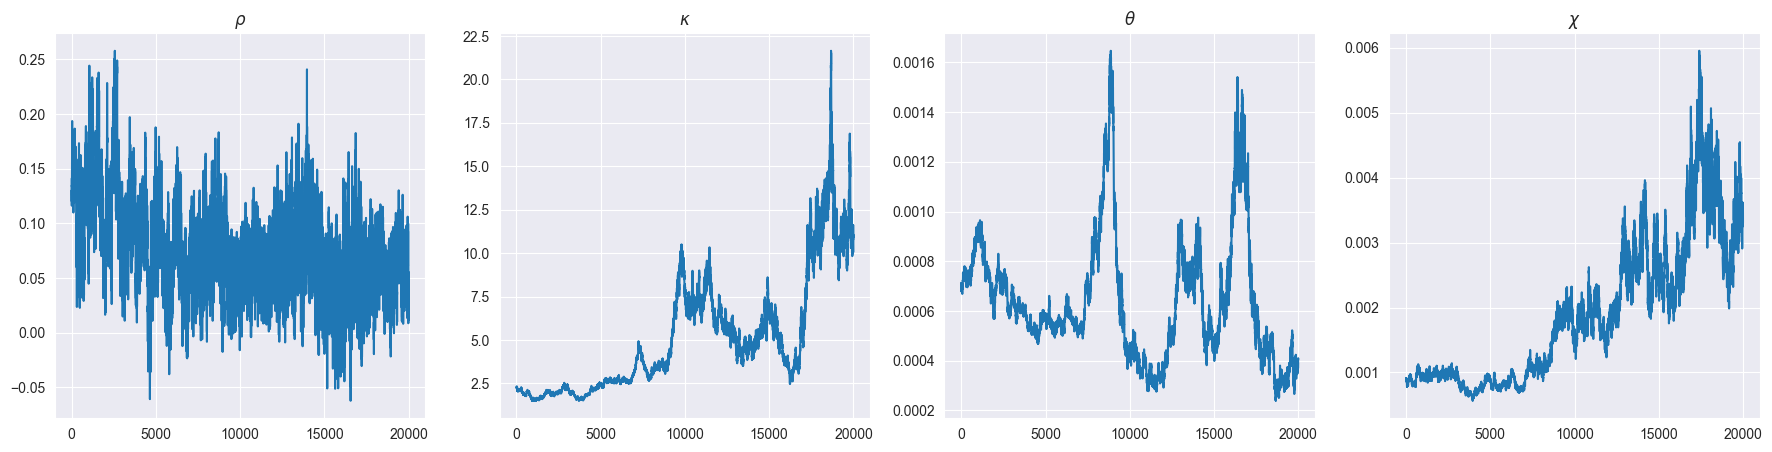

In [75]:
x_rwmh_samp, rho_rwmh_samp, kappa_rwmh_samp, theta_rwmh_samp, chi_rwmh_samp, acc = rwmh_sampler(x0 = X0, step_size = 1e-3,
                                                                                                n_iter = 5 * 10**7, burn_in = 3 * 10**7, thinning = 1000)

print(f"Acceptance rate: {acc:.3f}")
print(f"rho mean: {rho_rwmh_samp.mean():.3f}")
print(f"kappa mean: {kappa_rwmh_samp.mean():.3f}")
print(f"theta mean: {theta_rwmh_samp.mean():.3f}")
print(f"chi mean: {chi_rwmh_samp.mean():.3f}")

_, ax = plt.subplots(1, 4, figsize=(22, 5))
ax[0].plot(rho_rwmh_samp)
ax[0].set_title(r"$\rho$")
ax[1].plot(kappa_rwmh_samp)
ax[1].set_title(r"$\kappa$")
ax[2].plot(theta_rwmh_samp)
ax[2].set_title(r"$\theta$")
ax[3].plot(chi_rwmh_samp)
ax[3].set_title(r"$\chi$")
plt.show()

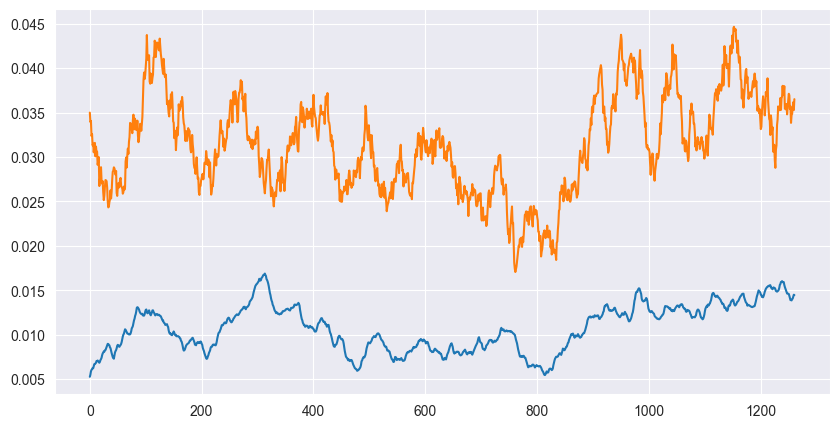

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(x_rwmh_samp[-100:, :].mean(axis = 0))
plt.plot(X)
plt.show()